# Project Baseline and Modeling
This notebook is focused creating a model baseline as well as trying several out of the box modeling methods.
## Import Statements

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

## Data Overview
We'll be working with two different dataframes in this section, one contains dummy variables for all columns and one that contains dummy variables for only unbalanced classes.

In [2]:
all_dummies  = pd.read_csv( 'All_Dummies_Clean.csv')
some_dummies = pd.read_csv('Some_Dummies_Clean.csv')
some_dummies = some_dummies.drop(columns=(['Unnamed: 0']))

Let's also go throug and stadnardize our features so that models that use record distance (SVMs and KNN) can be properly utilized.

In [3]:
def ZStandardize(array):
    mean = array.mean()
    std = array.std()
    new_array = (array - mean)/std
    return(new_array)

Now we'll standardize every column of the some_dummies dataframe. We'll ignore the columns if there is a only two possible values, ie binary.

In [4]:
for column in some_dummies.columns:
    if len(some_dummies[column].unique()) != 2:
        some_dummies[column] = ZStandardize(some_dummies[column])

In [5]:
some_dummies

,Officer_Years_of_Service,Driver_Age,Was_a_Search_Conducted,Male_Driver,BlackDriver,WhiteDriver,MetroDivision,NorthTryonDivision,Reason_for_Stop_CheckPoint,Reason_for_Stop_DrivingWhileImpaired,Reason_for_Stop_Investigation,Reason_for_Stop_Other,Reason_for_Stop_SafeMovement,Reason_for_Stop_SeatBelt,Reason_for_Stop_Speeding,Reason_for_Stop_StopLight/Sign,Reason_for_Stop_VehicleEquipment,Reason_for_Stop_VehicleRegulatory
0,1.842935,0.197767,0,0.0,0.0,1.0,0.0,0.0,0,0,0,0,0,0,1,0,0,0
1,-0.935648,-0.033222,0,1.0,1.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,1,0
2,0.569418,-0.495199,0,1.0,1.0,0.0,0.0,0.0,0,0,0,0,0,0,1,0,0,0
3,-0.819873,-0.187214,0,1.0,1.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,1,0
4,1.611387,0.043774,0,1.0,1.0,0.0,0.0,0.0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139523,-0.125228,-0.418203,0,0.0,1.0,0.0,0.0,0.0,0,0,0,0,0,0,1,0,0,0
139524,1.148290,0.967729,0,1.0,0.0,1.0,0.0,0.0,0,0,0,0,0,0,0,0,1,0
139525,0.106321,1.814687,0,0.0,0.0,1.0,0.0,0.0,0,0,0,0,0,0,1,0,0,0
139526,-0.356776,-0.033222,0,1.0,1.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,1,0


Let's get an idea of what the baseline will be for our model. Since both datasets have the same records, we can get a baseline for both at the same time. We'll create a function to get the baseline accuracy of a dataframe for later use.

In [6]:
def getBaseline(dataframe, save=False):
    search_conducted_mean = dataframe['Was_a_Search_Conducted'].mean()
    if (1 - search_conducted_mean) > search_conducted_mean:
        baseline = (1 - search_conducted_mean) * 100
        default = 'no'
    else:
        baseline = (search_conducted_mean) * 100
        default = 'yes'
    print(f'Baseline is {baseline}% by predicting all {default}')
    if save:
        return(baseline)

Now let's get the baseline for our original dataframe.

In [7]:
getBaseline(all_dummies)

Baseline is 94.34450432888023% by predicting all no


Because our baseline is so high and our target classes are so unbalanced, we should balance our target when we train the model. Now let's create a cross validation set using train_test_split and compare the baseline for the testing set. We'll start by utilizing the all dummies dataframe.

In [8]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(some_dummies, test_size=.2, random_state = 513)
getBaseline(test_set)

Baseline is 94.2772163692396% by predicting all no


Let's see how an out of the box model would fare in comparison to this baseline. We'll use a logistic regression model for this as we are using binary target variable. Logistic regression is one of the easier classification models to explain as because it is a linear model, we can use feature significance values to understand what's important and what's not. We'll be using the statsmodels.api implementation of logistic regression for this model.

In [9]:
import statsmodels.api as sma
from sklearn.metrics import *
clf = sma.Logit(train_set['Was_a_Search_Conducted'],train_set.drop(columns=['Was_a_Search_Conducted'])).fit()
print(clf.summary(),'\n')
predictions = clf.predict(test_set.drop(columns=['Was_a_Search_Conducted'])).apply(lambda x: round(x))
print(f'Accuracy of Logit model on validation set: {accuracy_score(test_set["Was_a_Search_Conducted"],predictions) *100}%')

Optimization terminated successfully.
         Current function value: 0.174940
         Iterations 9
                             Logit Regression Results                             
Dep. Variable:     Was_a_Search_Conducted   No. Observations:               111622
Model:                              Logit   Df Residuals:                   111605
Method:                               MLE   Df Model:                           16
Date:                    Thu, 15 Dec 2022   Pseudo R-squ.:                  0.1935
Time:                            16:15:03   Log-Likelihood:                -19527.
converged:                           True   LL-Null:                       -24212.
Covariance Type:                nonrobust   LLR p-value:                     0.000
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Officer_Years_of_Service

Unfortunately it looks like our logit model is running with the same exact accuracy as our baseline. We are likely encountering this problem as a sideeffect of an unbalanced dataset we are training on. We can diagnose this by analyzing the confusion matrix of our predictions. First we'll go through and create a good function for viewing a confusion matrix. As always, this function was gotten from https://github.com/DTrimarchi10/confusion_matrix/blob/master/cf_matrix.py. Article from author:https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea.

In [10]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

Now let's analyze how our model performed.

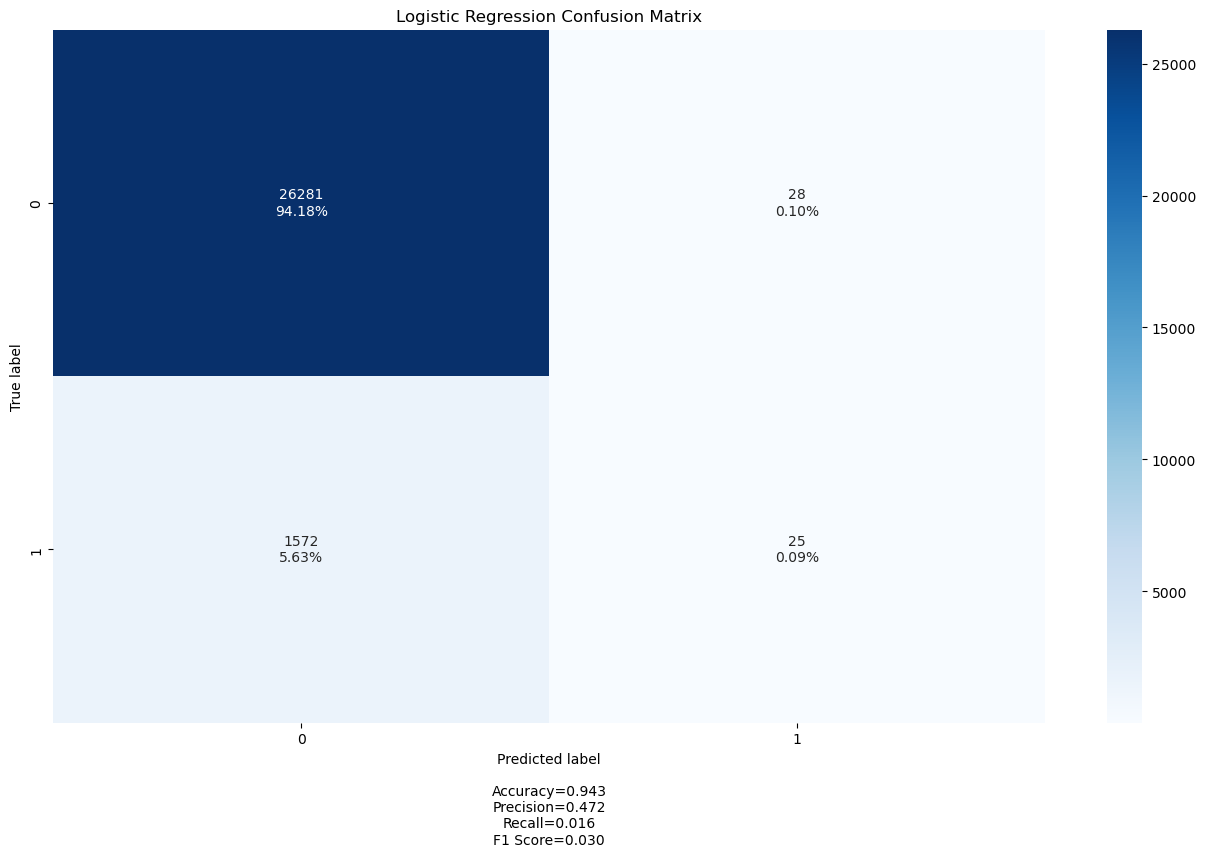

In [11]:
make_confusion_matrix(confusion_matrix(test_set["Was_a_Search_Conducted"],predictions),figsize=(16,9),
                     title='Logistic Regression Confusion Matrix')

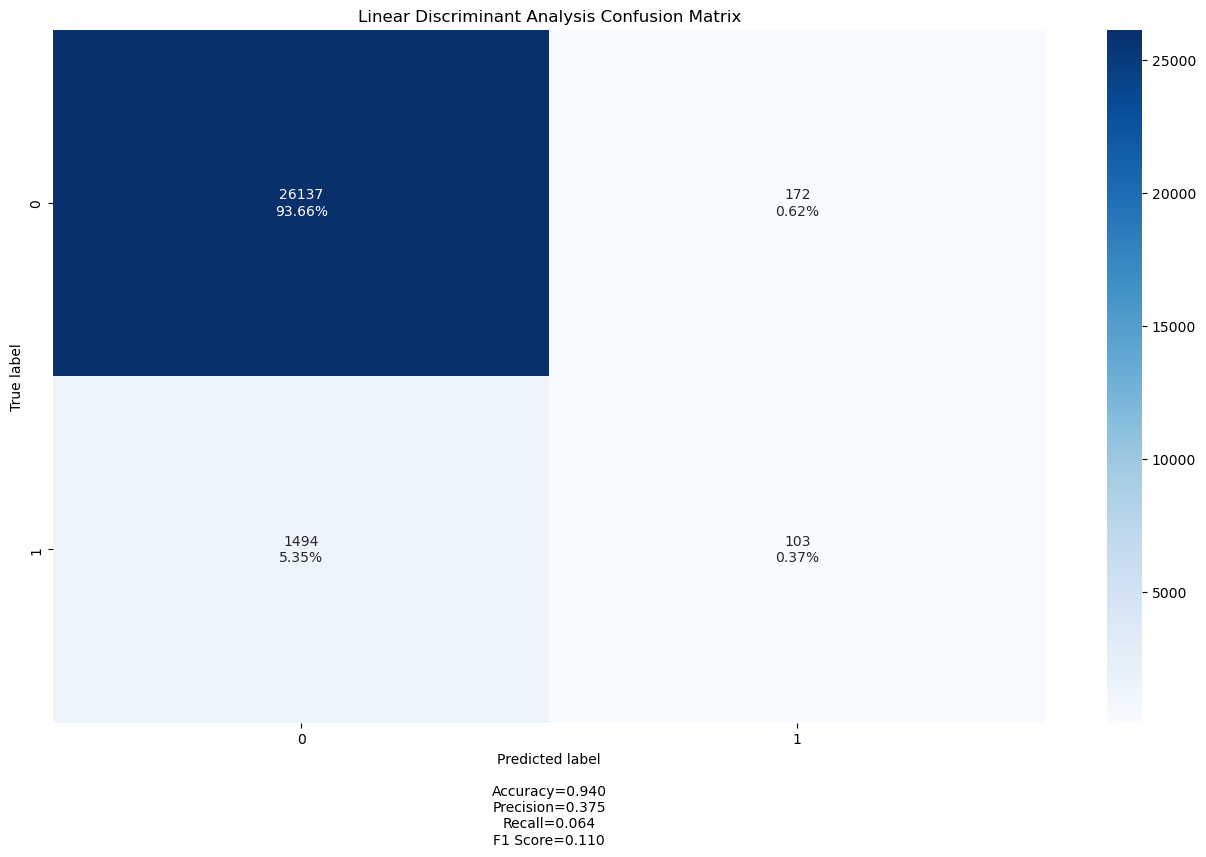

In [12]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
clf = LDA().fit(train_set.drop(columns=['Was_a_Search_Conducted']),train_set['Was_a_Search_Conducted'])
predictions = clf.predict(test_set.drop(columns=['Was_a_Search_Conducted']))
make_confusion_matrix(confusion_matrix(test_set["Was_a_Search_Conducted"],predictions),figsize=(16,9),
                     title='Linear Discriminant Analysis Confusion Matrix')

We can clearly see here that very few records are being predicted as a postive (indicating as search was conducted). We can clearly see now that the model isn't learning enough about the records that had searches conducted. Since we'll want to play around a little with different balancing sizes, let's create a function to balacnce the dataset.

In [13]:
def resampleTrainingSet(dataframe,resamplesize=.2):
    dataframe_copy = dataframe.copy()
    y = len(dataframe)
    x = (resamplesize * y - len(dataframe[dataframe['Was_a_Search_Conducted'] == 1]))/(1 - resamplesize)
    if x <=0:
        print('Resampled goal is smaller than original')
        return(dataframe_copy)
    else:
        to_resample = dataframe_copy.loc[dataframe_copy['Was_a_Search_Conducted']==1]
        our_sample = to_resample.sample(n=int(x),replace=True)
        return(pd.concat([dataframe_copy,our_sample]))

Now let's go through and recreate our model with a balanced dataset.

Optimization terminated successfully.
         Current function value: 0.255455
         Iterations 8
                             Logit Regression Results                             
Dep. Variable:     Was_a_Search_Conducted   No. Observations:               117031
Model:                              Logit   Df Residuals:                   117014
Method:                               MLE   Df Model:                           16
Date:                    Thu, 15 Dec 2022   Pseudo R-squ.:                  0.2142
Time:                            16:15:04   Log-Likelihood:                -29896.
converged:                           True   LL-Null:                       -38045.
Covariance Type:                nonrobust   LLR p-value:                     0.000
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Officer_Years_of_Service

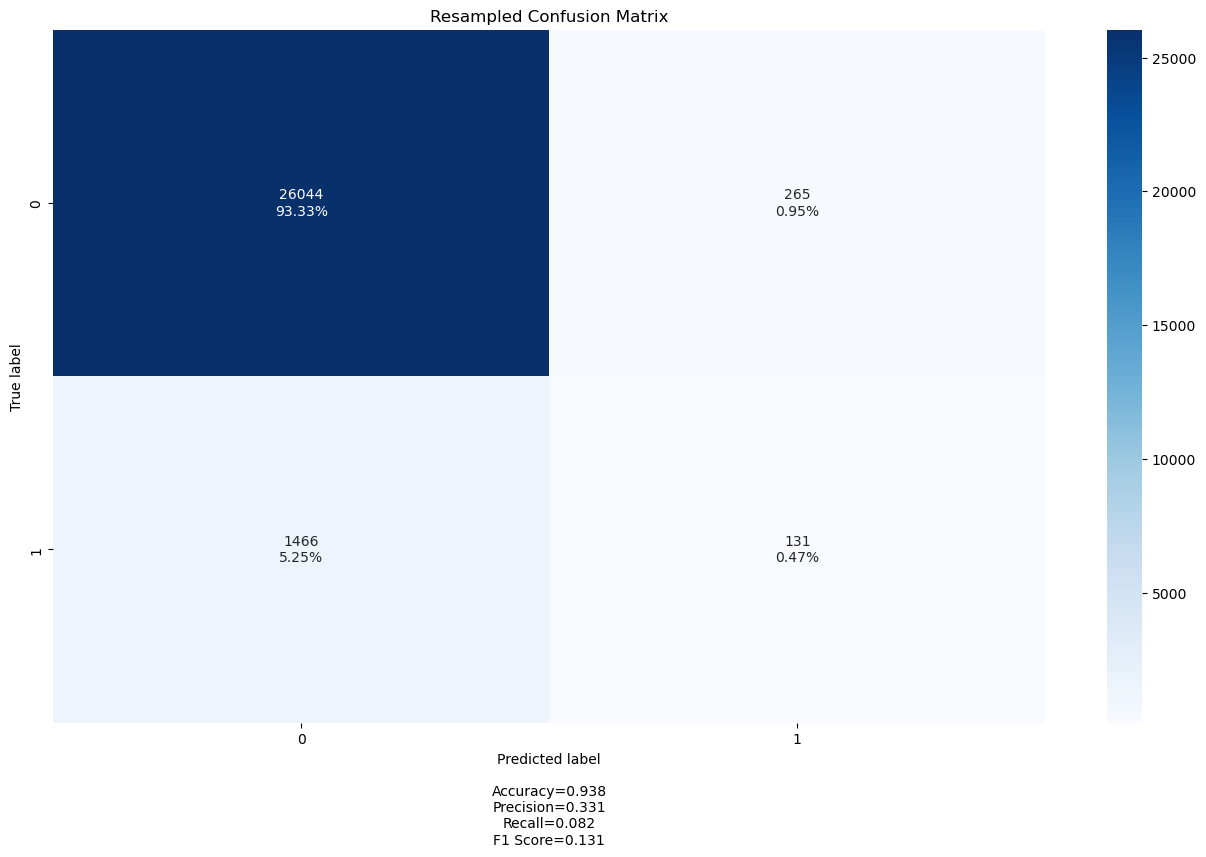

In [14]:
resampled = resampleTrainingSet(train_set,.1)
clf = sma.Logit(resampled['Was_a_Search_Conducted'],resampled.drop(columns=['Was_a_Search_Conducted']),).fit()
print(clf.summary(),'\n')
predictions = clf.predict(test_set.drop(columns=['Was_a_Search_Conducted'])).apply(lambda x: round(x))
print(f'Accuracy of Logit model on validation set: {accuracy_score(test_set["Was_a_Search_Conducted"],predictions) *100}%')
make_confusion_matrix(confusion_matrix(test_set["Was_a_Search_Conducted"],predictions),figsize=(16,9),
                     title='Resampled Confusion Matrix')

While we did lose some accuracy, we actually ended up predicting that people would be stopped. Let's try a bunch of different sample sizes.

Resampled goal is smaller than original
Optimization terminated successfully.
         Current function value: 0.174940
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.254290
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.324118
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.377729
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.417309
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.450283
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.496818
         Iterations 7


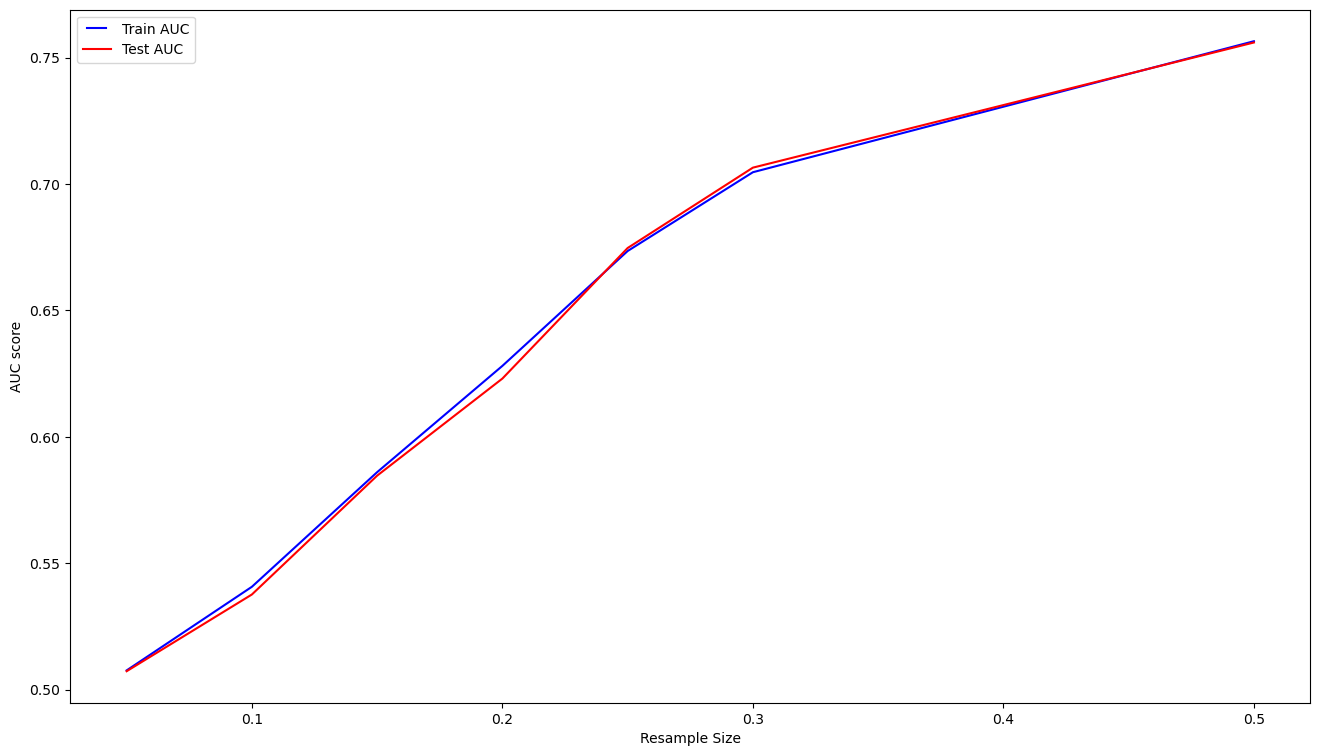

In [15]:
resample_size = [.05,.10,.15,.20,.25,.3,.5]
train_results = []
test_results  = []
for sample_size in resample_size:
    resampled = resampleTrainingSet(train_set,sample_size)
    clf = sma.Logit(resampled['Was_a_Search_Conducted'],resampled.drop(columns=['Was_a_Search_Conducted'])).fit()
    train_predictions = clf.predict(resampled.drop(columns=['Was_a_Search_Conducted'])).apply(lambda x: round(x))
    predictions = clf.predict(test_set.drop(columns=['Was_a_Search_Conducted'])).apply(lambda x: round(x))
    false_positive_rate, true_positive_rate, thresholds = roc_curve(resampled["Was_a_Search_Conducted"],train_predictions)
    train_results.append(auc(false_positive_rate,true_positive_rate))
    false_positive_rate, true_positive_rate, thresholds = roc_curve(test_set["Was_a_Search_Conducted"],predictions)
    test_results.append(auc(false_positive_rate,true_positive_rate))
plt.figure(figsize=(16,9))
line1, = plt.plot(resample_size,train_results,'b',label='Train AUC')
line2, = plt.plot(resample_size,test_results,'r',label='Test AUC')
plt.legend(handler_map={line1: matplotlib.legend_handler.HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Resample Size')
plt.show()

Even with the balanced dataset we weren't able to fix the problems with the model. Let's try a different type of model. This time we'll choose a decision tree based model.

Resampled goal is smaller than original


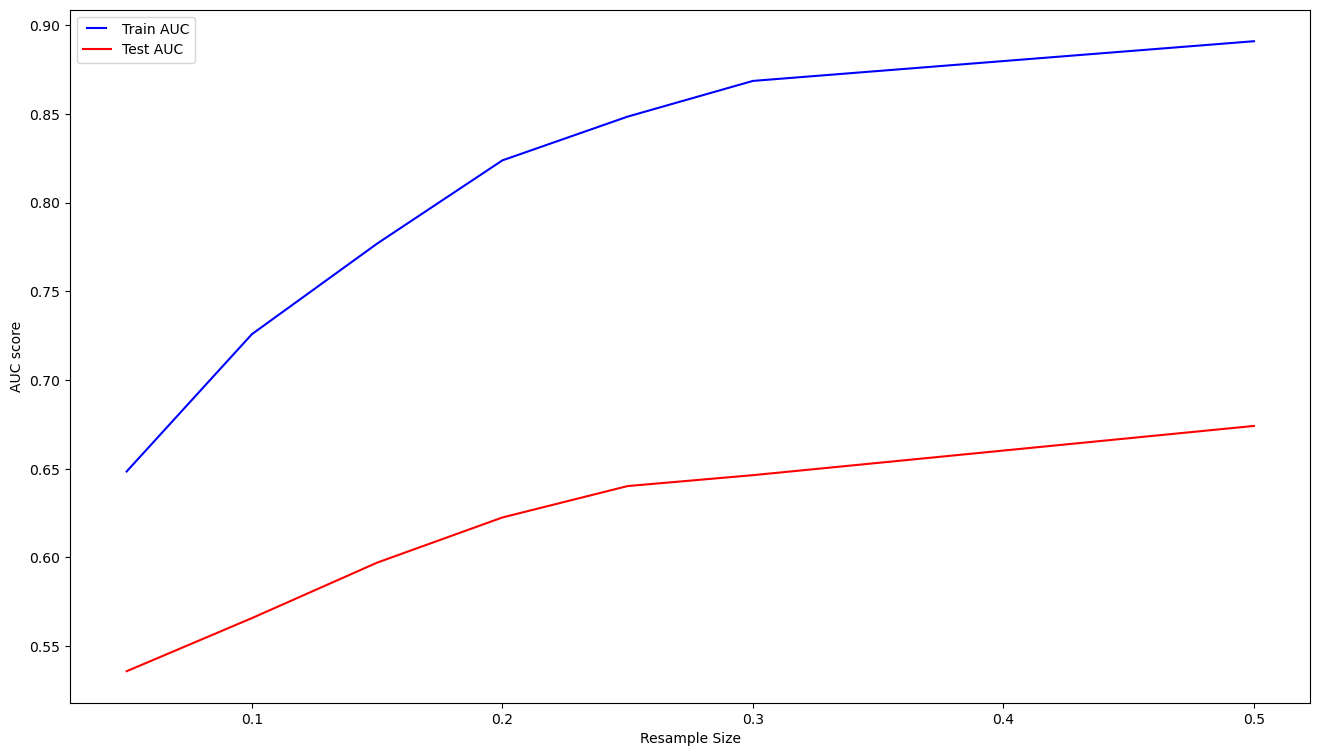

In [16]:
from sklearn.ensemble import RandomForestClassifier
resample_size = [.05,.10,.15,.20,.25,.3,.5]
train_results = []
test_results  = []
for sample_size in resample_size:
    resampled = resampleTrainingSet(train_set,sample_size)
    clf = RandomForestClassifier().fit(resampled.drop(columns=['Was_a_Search_Conducted']),resampled['Was_a_Search_Conducted'])
    train_predictions = clf.predict(resampled.drop(columns=['Was_a_Search_Conducted']))
    predictions = clf.predict(test_set.drop(columns=['Was_a_Search_Conducted']))
    false_positive_rate, true_positive_rate, thresholds = roc_curve(resampled["Was_a_Search_Conducted"],train_predictions)
    train_results.append(auc(false_positive_rate,true_positive_rate))
    false_positive_rate, true_positive_rate, thresholds = roc_curve(test_set["Was_a_Search_Conducted"],predictions)
    test_results.append(auc(false_positive_rate,true_positive_rate))
plt.figure(figsize=(16,9))
line1, = plt.plot(resample_size,train_results,'b',label='Train AUC')
line2, = plt.plot(resample_size,test_results,'r',label='Test AUC')
plt.legend(handler_map={line1: matplotlib.legend_handler.HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Resample Size')
plt.show()

Let's try with a subsetted dataframe.

In [17]:
Metro = some_dummies[some_dummies['MetroDivision'] == 1].drop(columns=['MetroDivision','NorthTryonDivision',
                                                                      'Reason_for_Stop_CheckPoint'])
Metro['BlackxAge'] = Metro['BlackDriver'] * Metro['Driver_Age']
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(Metro, test_size=.2, random_state = 513)
getBaseline(test_set)

Baseline is 82.43182834152883% by predicting all no


We see a much different baseline here. Let's run a logistic regression model on this subset.

Optimization terminated successfully.
         Current function value: 0.416750
         Iterations 7
                             Logit Regression Results                             
Dep. Variable:     Was_a_Search_Conducted   No. Observations:                 8945
Model:                              Logit   Df Residuals:                     8930
Method:                               MLE   Df Model:                           14
Date:                    Thu, 15 Dec 2022   Pseudo R-squ.:                  0.1032
Time:                            16:16:19   Log-Likelihood:                -3727.8
converged:                           True   LL-Null:                       -4156.7
Covariance Type:                nonrobust   LLR p-value:                4.640e-174
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Officer_Years_of_Service

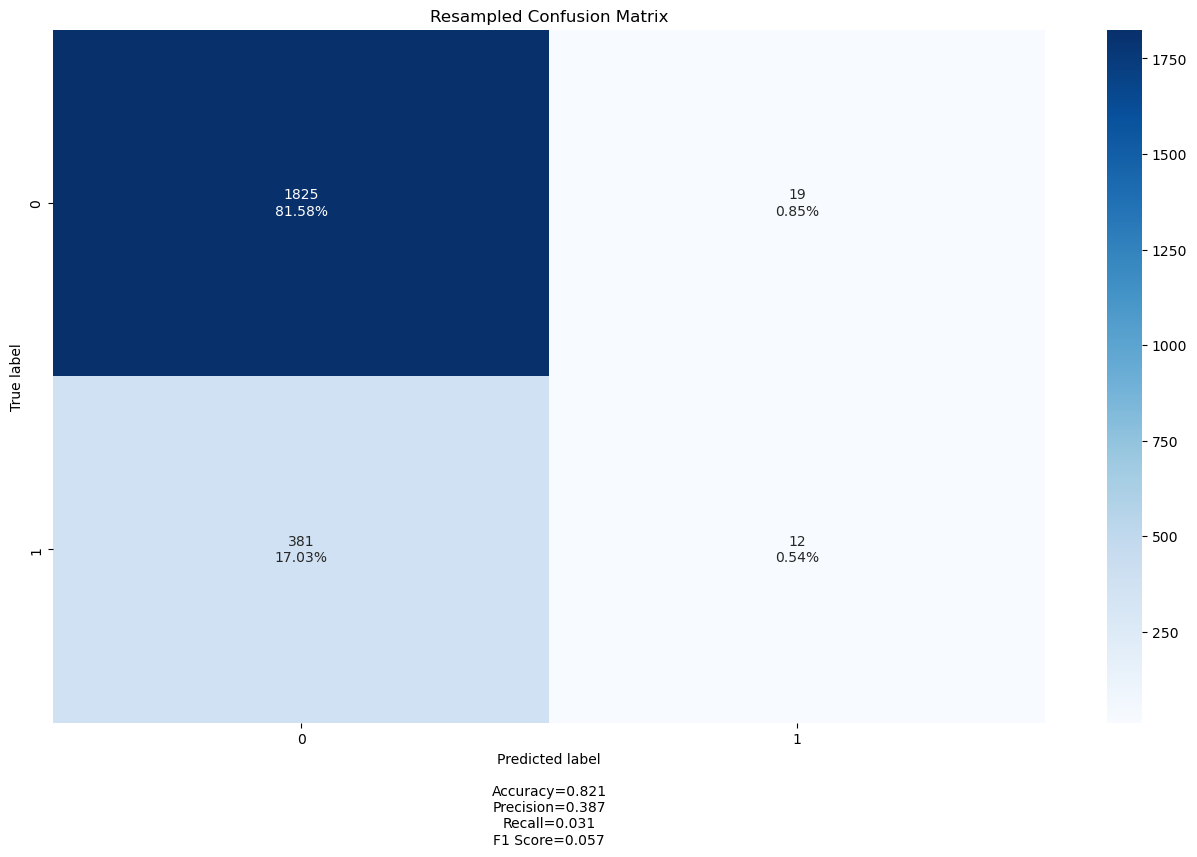

In [18]:
resampled = train_set
clf = sma.Logit(resampled['Was_a_Search_Conducted'],resampled.drop(columns=['Was_a_Search_Conducted'])).fit()
print(clf.summary(),'\n')
predictions = clf.predict(test_set.drop(columns=['Was_a_Search_Conducted'])).apply(lambda x: round(x))
print(f'Accuracy of Logit model on validation set: {accuracy_score(test_set["Was_a_Search_Conducted"],predictions) *100}%')
make_confusion_matrix(confusion_matrix(test_set["Was_a_Search_Conducted"],predictions),figsize=(16,9),
                     title='Resampled Confusion Matrix')

At this point our models are all performing and under the baseline accuracy. We should consider switching target variables or our success metric. If we only care to have quality analysis, then we have information from our logit model. If the goal of our project remains to have an accurate, above baseline predictive model that we analyze, then we need to change our target variable. 